In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import networkx.algorithms.bipartite as bipartite
from multiprocessing import Pool
import random
import itertools
import pandas as pd
from collections import Counter
from joblib import Parallel, delayed
import sys
from numba import njit,jit
from numba.typed import Dict,List
import numba as nb
from scipy.special import factorial
sys.path.append('lib/')
from degree_seq_bipartite import bipartite_degree_seq
import time
import pickle
from scipy.stats import pareto
def save_obj(obj, name ):
    with open('dic-'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)



module loaded at  2021-12-07 11:38:16.580463


Micorscopic cavity dynamics:
\begin{eqnarray}
v_i& \equiv \langle n_i\rangle =  1-\prod_{\mu \in\partial _i}\left(1-m_\mu^{(i)}\right)\\
m_\mu^{(i)}&\equiv\langle \tau_\mu^{(i)}\rangle = 1-\prod_{j\in\partial _\mu\setminus i}\left(1-T_{j\mu}v_j^{(\mu)}\right)\\
m_\mu^{(i)}&\equiv\langle \tau_\mu^{(i)}\rangle = 1-\prod_{j\in\partial _\mu\setminus i}\left(1-\frac{\tilde{T}_{j\mu}}{c_{\mu}}v_j^{(\mu)}\right)\\
v_j^{(\mu)}& \equiv\langle n_j^{(\mu)}\rangle = 1-\prod_{\nu\in\partial _j\setminus \mu }\left(1-m_\nu^{(j)}\right)\\
\end{eqnarray}
In the following I label ``a`` the quantities that refers to individuals, ``b`` for the clusters

In [35]:
N_a = 1_000# n people
N_b = 1_000 #n clusters
a_mean = 4. #average degree of the distribution
#b_mean = (a_mean )* N_a / N_b 
#aseq,bseq = bipartite_degree_seq(N_a,N_b,'shifted_poisson','shifted_poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})
aseq,bseq = bipartite_degree_seq(N_a,N_b,'poisson','poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})
BG = bipartite.generators.configuration_model(aseq,bseq)
BG = nx.Graph(BG)#convert multilinks to simple 
#G = nx.algorithms.bipartite.projection.projected_graph(BG,range(N_a,N_b))#projection on the cluster layer
p = 0.1 #probability to transmit a disease
min(bseq),min(aseq)

<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fe1882ceaf0>


(0, 0)

(array([ 219., 1122.,  911., 1583.,  535.,  481.,  122.,   16.,    9.,
           2.]),
 array([ 1. ,  2.6,  4.2,  5.8,  7.4,  9. , 10.6, 12.2, 13.8, 15.4, 17. ]),
 <a list of 10 Patch objects>)

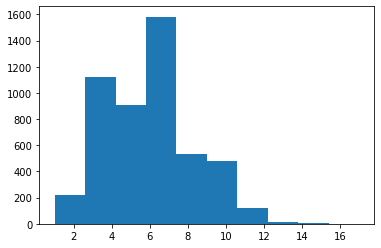

In [33]:
plt.hist(bseq)

In [36]:
def Convert_typed(tup):
    ''' for undirected edges. I construct the neighbouring relationship.
    Returns:
        di: dictionary.
    Notes:
    For link (a,b)  it returns the di[a]+=[b], and di[b]+=[a]
    '''
    d_typed = Dict.empty(
            key_type=nb.types.int64,
            value_type=nb.types.int64[:],
        )
    for a, b in tup:
        if a not in d_typed:
            d_typed[a]=np.array([b])
        else:
            d_typed[a]=np.append(d_typed[a],b)
        if b not in d_typed:
            d_typed[b]=np.array([a])
        else:
            d_typed[b]=np.append(d_typed[b],a)
            
    '''     
    for key, value in di.items():
        d_typed[key] = np.array(value,dtype=int) 
    '''
    return d_typed
def dict_to_typed_states(neigh):
    ''' for undirected edges. I construct the neighbouring relationship.
    Returns:
        di: dictionary.
    Notes:
    For link (a,b)  it returns the di[a]+=[b], and di[b]+=[a]
    '''
    d_typed = Dict.empty(
            key_type=nb.types.int64,
            value_type=nb.types.float32[:],
        )

    for key, value in neigh.items():
        d_typed[key] = np.ones(len(value),dtype=np.float32) 
    return d_typed
        
def Convert(tup, di=None):
    ''' for undirected edges. I construct the neighbouring relationship.
    Returns:
        di: dictionary.
    Notes:
    For link (a,b)  it returns the di[a]+=[b], and di[b]+=[a]
    '''
    if di ==None:
        di={}
    for a, b in tup: 
        di.setdefault(a, []).append(b)
        di.setdefault(b, []).append(a)
    di = {key:np.array(value,dtype=int) for key, value in di.items()}
    return di 
#%time neigh = Convert(BG.edges())
#states = {key:np.ones(len(value)) for key,value in neigh.items()}#states[x][y] indicates the state of node "x cavity neigh[x][y]""
%time neigh = Convert_typed(list(BG.edges()))
states = dict_to_typed_states(neigh)

CPU times: user 195 ms, sys: 16.8 ms, total: 212 ms
Wall time: 203 ms


Below the single instance cavity is computed. I use two dictionaries:
- states
- neigh

states[x][y] indicates the state of node "x cavity neigh[x][y]"".


Note : 'single_instance_numba' >  single_instance > single_instance2, where ">" means faster than

In [37]:
N_iterations = 50
#states = {key:np.ones(len(value)) for key,value in neigh.items()}#states[x][y] indicates the state of node "x cavity neigh[x][y]""
@njit
def single_instance_numba(neigh,states,p):
    individuals = set(range(N_a)).intersection(set(neigh.keys())) 
    clusters = set(range(N_a,N_a+N_b)).intersection(set(neigh.keys()))
    #start = time.time()
    for count in range(N_iterations):    #solving cavity equations through forward dynamics
        err = 0
        for j in individuals:#solving 3rd equation
                for idx,mu in enumerate(neigh[j]):
                    new=1.0
                    for nu in set(neigh[j])-{mu}:
                        new*=1-states[nu][neigh[nu]==j][0]
                    err = max(abs(states[j][idx]-1+new),err)
                    states[j][idx]= 1-new
        for mu in clusters: #running 2nd equation
                for idx,i in enumerate(neigh[mu]):
                    new=1.
                    for j in set(neigh[mu])-{i}:
                        new*=(1-p*states[j][neigh[j]==mu][0])
                    err = max(abs(1-new-states[mu][idx]),err)
                    states[mu][idx]= 1-new
        if err<0.001:
            print('Exit after ',count,' iterations')
            break
    if count==N_iterations-1:
        print('Attention! Maximum number of iteration reached')
    #end = time.time()
    #print('it took',end-start,' seconds')

    risk ={}
    for i in individuals:#solving 3rd equation
        new=1
        for mu in set(neigh[i]):
            if len(states[nu][neigh[mu]==i])!=1:#sanity check
                raise ValueError
            new*=(1-states[mu][neigh[mu]==i][0])
        risk[i]= 1-new
    return risk

def single_instance(neigh,states,p):
    individuals = set(range(N_a)).intersection(set(neigh.keys())) 
    clusters = set(range(N_a,N_a+N_b)).intersection(set(neigh.keys()))
    #start = time.time()
    for count in range(N_iterations):    #solving cavity equations through forward dynamics
        for j in individuals:#solving 3rd equation
                for idx,mu in enumerate(neigh[j]):
                    new=1.
                    for nu in set(neigh[j])-{mu}:
                        new*=(1-states[nu][neigh[nu]==j])
                    states[j][idx]= 1-new
        for mu in clusters: #running 2nd equation
                for idx,i in enumerate(neigh[mu]):
                    new=1.
                    for j in set(neigh[mu])-{i}:
                        new*=(1-p*states[j][neigh[j]==mu])
                    states[mu][idx]= 1-new
    #end = time.time()
    #print('it took',end-start,' seconds')

    risk ={}
    for i in individuals:#solving 3rd equation
        new=1
        for mu in set(neigh[i]):
            new*=(1-states[mu][neigh[mu]==i])
        risk[i]= 1-new
    return risk

def single_instance2(neigh,states):
    individuals = set(range(N_a)).intersection(set(neigh.keys())) 
    clusters = set(range(N_a,N_a+N_b)).intersection(set(neigh.keys()))
    #start = time.time()
    for count in range(N_iterations):    #solving cavity equations through forward dynamics
        for j in individuals:#solving 3rd equation
                data = []
                for mu in neigh[j]:
                    data+= [1.- np.prod([1.-states[nu][neigh[nu]==j] for nu in set(neigh[j])-{mu}])]
                states[j]=np.array(data)
        for mu in clusters: #running 2nd equation
                data=[]
                for i in neigh[mu]:
                    data+= [1- np.prod([1-p*states[j][neigh[j]==mu] for j in set(neigh[mu])-{i}])]
                states[mu]=np.array(data)
    '''
    a = [np.ravel(el) for el in a]
    b = [np.ravel(el) for el in b]
    states = dict(zip(individuals|clusters,a+b))
    '''
    #end = time.time()
    #return states
    #print('it took',end-start,' seconds')
    risk ={}
    for i in individuals:#solving 3rd equation
        risk[i] = 1-np.prod([1.-states[mu][neigh[mu]==i] for mu in set(neigh[i])])
    return risk

 

In [38]:
#%time risk = single_instance(neigh,states)
#%time risk2 = single_instance2(neigh,states)
%time risk2 = single_instance_numba(neigh,states,p)

Exit after  11  iterations
CPU times: user 4.04 s, sys: 69.2 ms, total: 4.11 s
Wall time: 5.39 s


In [18]:
np.mean([el for el in risk2.values() ])


0.5558603417397091

Text(0.5, 1.0, '100000 inh., 100000 clusters, <cluster size> = 4.0, p=0.1')

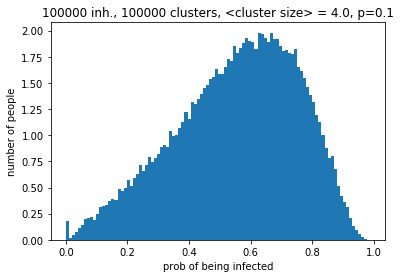

In [15]:
#plt.hist([el for el in states.values() ],bins = 50)
plt.hist([el for el in risk2.values()],bins = 100,density = True)
plt.xlabel('prob of being infected')
plt.ylabel('number of people')
plt.title(str(N_a)+' inh., '+str(N_b)+' clusters, <cluster size> = '+str(N_a*a_mean/N_b)+', p=' + str(p))
#plt.savefig('single_instance.pdf')
#plt.semilogy()

(array([1332.,  460.,  591.,  642.,  660.,  603.,  569.,  486.,  494.,
         484.,  435.,  430.,  385.,  318.,  309.,  250.,  247.,  185.,
         151.,  135.,  109.,   70.,   60.,   54.,   39.,   31.,   33.,
          17.,   21.,    3.,    6.,    4.,    2.,    7.,    3.,    0.,
           3.,    2.,    2.,    2.]),
 array([0.        , 0.0101457 , 0.0202914 , 0.0304371 , 0.0405828 ,
        0.0507285 , 0.0608742 , 0.0710199 , 0.0811656 , 0.0913113 ,
        0.101457  , 0.1116027 , 0.12174841, 0.13189411, 0.14203981,
        0.15218551, 0.16233121, 0.17247691, 0.18262261, 0.19276831,
        0.20291401, 0.21305971, 0.22320541, 0.23335111, 0.24349681,
        0.25364251, 0.26378821, 0.27393391, 0.28407961, 0.29422531,
        0.30437101, 0.31451671, 0.32466241, 0.33480811, 0.34495381,
        0.35509952, 0.36524522, 0.37539092, 0.38553662, 0.39568232,
        0.40582802]),
 <a list of 40 Patch objects>)

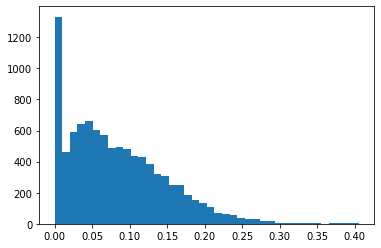

In [36]:
#list(states.values())
plt.hist(list(map(lambda x:max(x)-min(x),states.values()))[10000:],40)

Text(0, 0.5, '$\\sum_im_\\mu^{(i)}$')

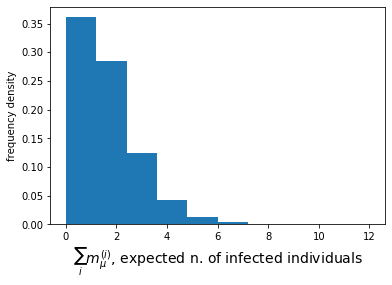

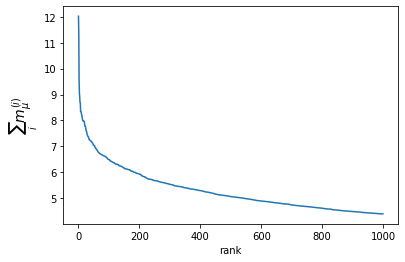

In [65]:
risk_clusters = {mu:sum(states[mu]) for mu in range(N_a,N_a+N_b)}
plt.hist(risk_clusters.values(),density=True)
plt.xlabel('$\\sum_im_\mu^{(i)}$, expected n. of infected individuals',fontsize = 14)
plt.ylabel('frequency density')
plt.figure()
plt.plot(sorted(risk_clusters.values(),reverse=True)[:1000])
plt.xlabel('rank')
plt.ylabel('$\\sum_im_\mu^{(i)}$',fontsize = 14)

Text(0, 0.5, 'degree of $\\mu$')

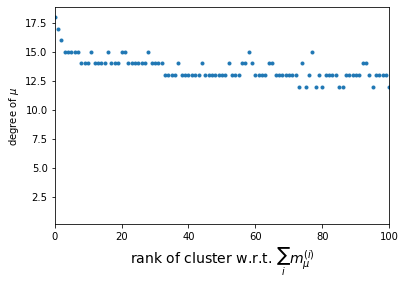

In [71]:
ranked_risk =sorted(risk_clusters,key = risk_clusters.get,reverse=True)
plt.plot(list(map(lambda x:x[1],BG.degree(ranked_risk))),'.')
plt.xlim(0,100)
plt.xlabel('rank of cluster w.r.t. $\\sum_im_\mu^{(i)}$',fontsize=14)
plt.ylabel('degree of $\mu$')

In [60]:
BG_filt = BG.copy()
BG_filt.remove_nodes_from(ranked_risk[:1000])
neigh_filt = Convert(BG_filt.edges())
states_filt = {key:np.ones(len(value)) for key,value in neigh_filt.items()}#states[x][y] indicates the state of node "x cavity neigh[x][y]""
risk_filt = single_instance(neigh_filt,states_filt)

it took 382.89174580574036  seconds


In [18]:
#ranked_risk[0] in list(map(lambda x:x[1],BG_filt.edges()))
#neigh_filt[ranked_risk[0]]
#len(np.unique(list(map(lambda x:x[0],BG_filt.edges()))))
neigh[1],neigh_filt[1]
Convert([(1,2)],{})

{1: array([2]), 2: array([1])}

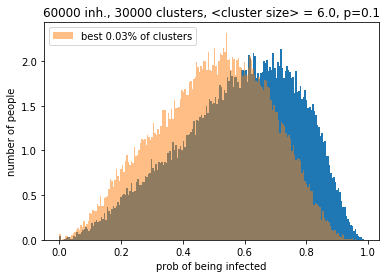

In [67]:

plt.hist([x for el in risk.values() for x in el],bins = 200,density = True)
plt.hist([x for el in risk_filt.values() for x in el],bins = 200,density = True,alpha = 0.5,label = 'best '+str(round(1-len(set(BG_filt.nodes()).intersection(set(range(N_a,N_a+N_b))))/N_b,2))+'% of clusters')
plt.xlabel('prob of being infected')
plt.ylabel('number of people')
plt.title(str(N_a)+' inh., '+str(N_b)+' clusters, <cluster size> = '+str(N_a*a_mean/N_b)+', p=' + str(p))
plt.legend()
#plt.savefig('target_delition.pdf')


In [69]:
dic = {'states':states,'states_filt':states_filt,'neigh':neigh,'neigh_filt':neigh_filt,'risk':risk,'risk_filt':risk_filt}
save_obj(dic,'single_instance')

## Projected graph

$$
v_j^{(k)} \equiv\langle n_j^{(k)}\rangle = 1-\prod_{\nu\in\partial _j\setminus k }\left(1-pv_\nu^{(j)}\right)
$$
$$
v_i \equiv\langle n_i\rangle = 1-\prod_{j\in\partial _i }\left(1-pv_j\right)
$$

In [143]:
G = nx.algorithms.bipartite.projected_graph(BG,range(N_a))
neigh = Convert(G.edges())
states = {key:np.ones(len(value)) for key,value in neigh.items()}#states[x][y] indicates the state of node "x cavity neigh[x][y]""

In [ ]:
def update(j,neighbour):
    '''Returns the cavity states associated to  node j'''
    #neighbour is neigh[j]
    data = []
    for idx,k in enumerate(neighbour):
        new=1    
        for nu in set(neighbour)-{k}:
            new*=(1-p*states[nu][neigh[nu]==j])
        states[j][idx]+=[1-new]
individuals = set(range(N_a)).intersection(set(neigh.keys()))
#solving 3rd equation
start = time.time()
#pool = Pool()
for count in range(N_iterations):
    for j,neighbour in neigh.items():
        update(j,neighbour)
#a = pool.starmap(update, neigh.items())
#pool.close()
end = time.time()
print('It tooks ',end-start, ' seconds')
risk ={}
for i in individuals:#solving 3rd equation
    risk[i] = 1-np.prod([1-p*states[j][neigh[j]==i] for j in set(neigh[i])])

#states[j][idx]= 1-new
 

(array([2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 4.000e+00,
        1.100e+01, 1.500e+01, 4.400e+01, 5.916e+03]),
 array([0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]),
 <a list of 10 Patch objects>)

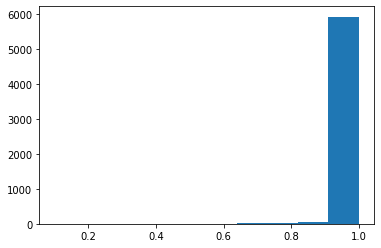

In [185]:
plt.hist(risk.values())
#new*(1-states[mu][neigh[mu]==i])


In [55]:
start = time.time()
new = 1
for mu in set(neigh[i]):
        new *=(1-states[mu][neigh[mu]==i])
end = time.time()
print('It tooks ',(end-start)*1000, ' ms')
%time np.prod([1-states[mu][neigh[mu]==i] for mu in set(neigh[i])])


It tooks  0.43773651123046875  ms
CPU times: user 488 µs, sys: 246 µs, total: 734 µs
Wall time: 595 µs


4.115390615893796e-32

In [56]:
new

array([4.11539062e-32])

## Population dynamics

In [29]:
df = pd.read_csv('/Data/SISIR-Bip-N1+P1M1+P3-p0.3',sep = '   ',names =['v','prob'])

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


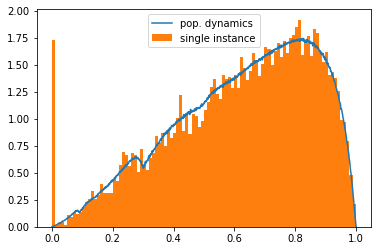

In [12]:
plt.plot(*zip(*df.iloc[1:].values),label = 'pop. dynamics')
plt.hist([x for el in risk.values() for x in el],bins = 100,density = True,label='single instance')
plt.legend()
#plt.savefig('pop_vs_single.pdf')

In [227]:
import random

In [20]:
Np_a  = 20000#size of population of indivuals
Np_b  = 20000#size of population of clusters
N_iterations = 10
N_measures = 10000
a_mean = 4
b_mean = 4
k = np.arange(1,10)

p_aseq = random.choices(k,np.exp(-a_mean)*a_mean**(k-1)/factorial(k-1),k =  Np_a*N_iterations)
q_aseq = random.choices(k,np.exp(-a_mean)*a_mean**(k-1)*k/factorial(k-1),k =  Np_a*N_iterations)
q_bseq = random.choices(k,np.exp(-b_mean)*b_mean**(k-1)*k/factorial(k-1),k =  Np_a*N_iterations)
p = 0.1

In [21]:
a_cav =np.array(list(np.ones(Np_a)))
b_cav =np.ones(Np_b)#initialisation of cavity variable of clusters

In [22]:
for count in range(N_iterations):
    for i,mu in zip(range(Np_a),range(Np_b)): #it works if Np_a = Np_b
        nu =random.sample(range(len(b_cav)),q_aseq.pop())#  mu are the neighbours
        j = random.sample(range(len(a_cav)),q_bseq.pop())#  j are the neighbours
        a_cav[i] = 1-(np.prod(1-np.array(b_cav[nu])))
        b_cav[mu] = 1-(np.prod(1-p*np.array(a_cav[j])))
risk_a = []
risk_b = []
for i,mu in zip(range(Np_a),range(Np_b)): #it works if Np_a = Np_b
    nu =random.sample(range(len(b_cav)),p_aseq.pop())#  mu are the neighbours
    risk_a += [1-(np.prod(1-np.array(b_cav[nu])))]
    

    
    

Text(0.5, 0, 'risk')

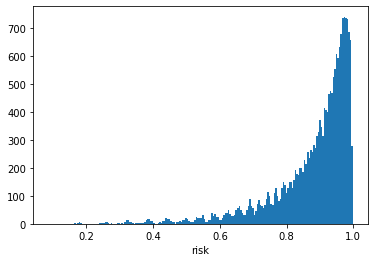

In [23]:
plt.hist(risk_a,200)
plt.xlabel('risk')

# Structured network

In [2]:
def _add_nodes_with_bipartite_label(G, lena, lenb):
    G.add_nodes_from(range(0,lena+lenb))
    b=dict(zip(range(0,lena),[0]*lena))
    b.update(dict(zip(range(lena,lena+lenb),[1]*lenb)))
    if nx.__version__>'2':
         nx.set_node_attributes(G,b,'bipartite')
    else:
         nx.set_node_attributes(G,'bipartite',b)
    return G

N_a = 40_000# n people
N_b = 40_000 #n clusters
f_n = [0.25,0.25,0.5] # fraction of people in group n
g_a = [0.4,0.5,0.1] # fraction of clusters in group a
G = nx.empty_graph(0, default=nx.Graph)
G = _add_nodes_with_bipartite_label(G, N_a, N_b)
p = 0.2

a_mean = 3. #average degree of the distribution
#b_mean = (a_mean )* N_a / N_b 
#aseq,bseq = bipartite_degree_seq(N_a*f_n[0],N_b*g_a[0],'shifted_poisson','shifted_poisson',{'lam':a_mean},{'lam':N_a*a_mean/N_b})


In [71]:
G = nx.empty_graph(0, default=nx.Graph)
G = _add_nodes_with_bipartite_label(G, N_a, N_b)
a_stubs = range(int(N_a*f_n[0]))
b_stubs = random.choices(np.arange(N_a,int(N_a+N_b*g_a[0])),k = int(N_a*f_n[0]))
G.add_edges_from(zip(a_stubs,b_stubs))#n=0->a=0 

aseq,bseq = bipartite_degree_seq(int(N_a*f_n[1]),int(N_b*g_a[0]),'poisson','poisson',{'lam':1},{'lam':5/8}) 
a_stubs = itertools.chain.from_iterable([[i+int(N_a*f_n[0])]*k for i,k in enumerate(aseq) if k >0])
b_stubs = list(itertools.chain.from_iterable([[mu+ N_a]*k for mu,k in enumerate(bseq) if k >0]))
random.shuffle(b_stubs)
G.add_edges_from(zip(a_stubs,b_stubs))#n=1->a=0

aseq,bseq = bipartite_degree_seq(int(N_a*f_n[2]),int(N_b*g_a[0]),'shifted_poisson','poisson',{'lam':2},{'lam':5/2})#n=2->a=0 
a_stubs = itertools.chain.from_iterable([[i+int(N_a*(f_n[1]+f_n[0]))]*k for i,k in enumerate(aseq) if k >0])
b_stubs = list(itertools.chain.from_iterable([[mu+ N_a]*k for mu,k in enumerate(bseq) if k >0]))
random.shuffle(b_stubs)
_ = G.add_edges_from(zip(a_stubs,b_stubs))

aseq,bseq = bipartite_degree_seq(int(N_a*f_n[1]),int(N_b*g_a[1]),'poisson','poisson',{'lam':1},{'lam':1/2})#n=1->a=1 
a_stubs = itertools.chain.from_iterable([[i+int(N_a*f_n[0])]*k for i,k in enumerate(aseq) if k >0])
b_stubs = list(itertools.chain.from_iterable([[mu+ N_a+int(N_b*g_a[0])]*k for mu,k in enumerate(bseq) if k >0]))
random.shuffle(b_stubs)
G.add_edges_from(zip(a_stubs,b_stubs))

aseq,bseq = bipartite_degree_seq(int(N_a*f_n[2]),int(N_b*g_a[1]),'poisson','poisson',{'lam':1},{'lam':1})#n=2->a=1 
a_stubs = itertools.chain.from_iterable([[i+int(N_a*(f_n[1]+f_n[0]))]*k for i,k in enumerate(aseq) if k >0])
b_stubs = list(itertools.chain.from_iterable([[mu+ N_a+ int(N_b*g_a[0])]*k for mu,k in enumerate(bseq) if k >0]))
random.shuffle(b_stubs)
G.add_edges_from(zip(a_stubs,b_stubs))

aseq,bseq = bipartite_degree_seq(int(N_a*f_n[2]),int(N_b*g_a[2]),'poisson','poisson',{'lam':1},{'lam':5})#n=2->a=2 
a_stubs = itertools.chain.from_iterable([[i+int(N_a*(f_n[1]+f_n[0]))]*k for i,k in enumerate(aseq) if k >0])
b_stubs = list(itertools.chain.from_iterable([[mu+ N_a+ int(N_b*(g_a[1]+g_a[0]))]*k for mu,k in enumerate(bseq) if k >0]))
random.shuffle(b_stubs)
_ = G.add_edges_from(zip(a_stubs,b_stubs))


<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fafcf0beaf0>
<function shifted_poisson at 0x7fafd28813b0>
<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fafcf0beaf0>
<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fafcf0beaf0>
<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fafcf0beaf0>


Text(0.5, 1.0, '$\\alpha=1$')

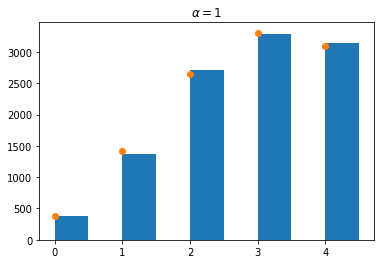

In [72]:
plt.hist(list(dict(G.degree(range(N_a,int(N_a+N_b*(g_a[0]))))).values()),bins = np.arange(0,5,0.5))
k = np.arange(0,5,1)
plt.plot(k,np.exp(-15/4)*(15/4)**k/factorial(k)*N_b*(g_a[0]),'o')#5/4*2+5/2
plt.title('$\\alpha=1$')

Text(0.5, 1.0, '$\\alpha=3$')

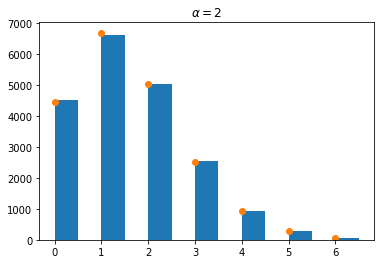

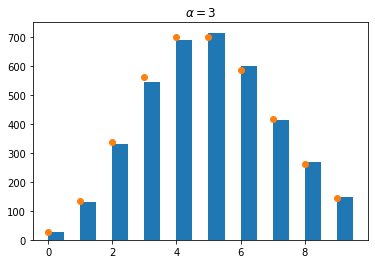

In [73]:
plt.hist(list(dict(G.degree(range(int(N_a+N_b*(g_a[0])),int(N_a+N_b*(g_a[1]+g_a[0]))))).values()),bins = np.arange(0,7,0.5))
k = np.arange(0,7,1)
plt.plot(k,np.exp(-3/2)*(3/2)**k/factorial(k)*N_b*(g_a[1]),'o')#1/2+1
plt.title('$\\alpha=2$')
plt.figure()
plt.hist(list(dict(G.degree(range(int(N_a+N_b*(g_a[0]+g_a[1])),int(N_a+N_b*(g_a[1]+g_a[0]+g_a[2]))))).values()),bins = np.arange(0,10,0.5))
k = np.arange(0,10,1)
plt.plot(k,np.exp(-5)*(5)**k/factorial(k)*N_b*(g_a[2]),'o')#5/4*2+5/2
plt.title('$\\alpha=3$')

In [129]:
%%time
#neigh = Convert(G.edges())
#states = {key:np.ones(len(value)) for key,value in neigh.items()}#states[x][y] indicates the state of node "x cavity neigh[x][y]""
neigh = Convert_typed(list(G.edges()))
states = dict_to_typed_states(neigh)

CPU times: user 2min 24s, sys: 3.06 s, total: 2min 27s
Wall time: 2min 37s


In [136]:
p = 0.1
risk = single_instance_numba(neigh,states,p)

Exit after  14  iterations


Text(0.5, 1.0, 'structured network,p=0.1')

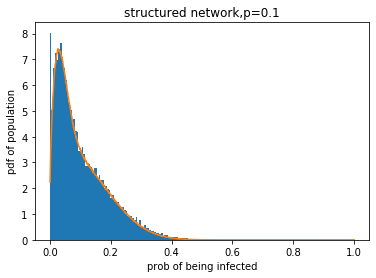

In [137]:
#plt.hist([x for el in risk.values() for x in el],bins = 100,density = True)
plt.hist([el for el in risk.values() ],bins = 100,density = True)
plt.plot(df.v,df.prob)
plt.xlabel('prob of being infected')
plt.ylabel('pdf of population')
plt.title('structured network,p='+str(p))
#plt.ylim(0,10)
#plt.semilogy()
#plt.savefig('structured.pdf')

In [77]:
np.mean([x for el in risk.values() for x in el])


0.14766258170617066

In [86]:
p = 0.3
risk03 = single_instance(neigh,states)

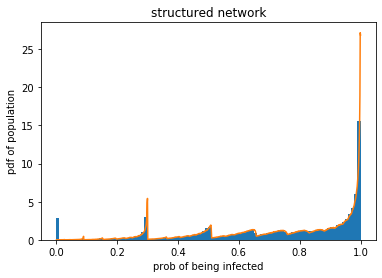

In [90]:
plt.hist([x for el in risk03.values() for x in el],bins = 100,density = True)
#plt.hist([el for el in risk.values() ],bins = 100,density = True)
plt.plot(df.v,df.prob)
plt.xlabel('prob of being infected')
plt.ylabel('pdf of population')
plt.title('structured network')
#plt.savefig('structured_p=0.3.pdf')


Text(0.5, 1.0, 'degree distribution of clusters')

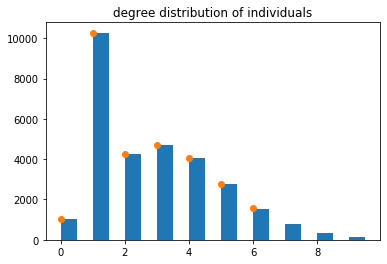

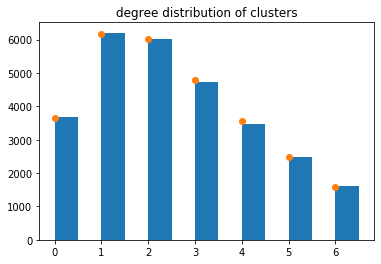

In [195]:
plt.hist(list(dict(G.degree(range(N_a))).values()),bins = np.arange(0,10,0.5))
k = np.arange(0,7,1)
plt.title('degree distribution of individuals')
x = np.pad([0,N_a*(f_n[0])],(0,len(k)-2))+np.exp(-2)*(2)**k/factorial(k)*N_a*(f_n[1])+np.pad((np.exp(-3)*(3)**(k[:-1])/factorial(k[:-1]))*N_a*(f_n[2]),(1,0))
plt.plot(k,x,'o')

plt.figure()
plt.hist(list(dict(G.degree(range(N_a,N_a+N_b))).values()),bins = np.arange(0,7,0.5))
k = np.arange(0,7,1)
plt.plot(k,np.exp(-3/2)*(3/2)**k/factorial(k)*N_b*(g_a[1])+np.exp(-5)*(5)**k/factorial(k)*N_b*(g_a[2])+np.exp(-15/4)*(15/4)**k/factorial(k)*N_b*(g_a[0]),'o')#1/2+1
plt.title('degree distribution of clusters')

In [78]:
d = np.array(list(dict(G.degree(range(N_a))).values()))
c = np.array(list(dict(G.degree(range(N_a,N_b+N_a))).values()))
print('condition for being above the percolation thr. is: ',(np.mean(d**2)/np.mean(d)-1)*(np.mean(c**2)/np.mean(c)-1)*p,' >1')

condition for being above the percolation thr. is:  1.0474716587442423  >1


In [91]:
#comparison with population dynamics
#df = pd.read_csv('Data/SIRBStrPopDyn-P-tb01Np10k',sep = '   ',skiprows=1,usecols=[1,5],names =['v','prob'])
df = pd.read_csv('./Data/SIRBStrPopDyn-P-tb01',sep = '   ',skiprows=1,usecols=[1,5],names =['v','prob'])
print(np.dot(df.prob,df.v)*0.001,' mean activation prob')
df

0.09754262020181631  mean activation prob


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,v,prob
0,0.001,2.232746
1,0.002,2.962067
2,0.003,3.465350
3,0.004,3.798805
4,0.005,4.149086
...,...,...
995,0.996,0.000000
996,0.997,0.000000
997,0.998,0.000000
998,0.999,0.000000


### Comparison with the unstructured

In [79]:
k_mean =  sum(dict(G.degree(range(N_a))).values())/N_a
aseq,bseq = bipartite_degree_seq(N_a,N_b,'poisson','poisson',{'lam':k_mean},{'lam':k_mean})
a_stubs = itertools.chain.from_iterable([[i]*k for i,k in enumerate(aseq) if k >0])
b_stubs = list(itertools.chain.from_iterable([[mu+ N_a]*k for mu,k in enumerate(bseq) if k >0]))
random.shuffle(b_stubs)
G_unstr = nx.empty_graph(0, default=nx.Graph)
G_unstr = _add_nodes_with_bipartite_label(G_unstr, N_a, N_b)
G_unstr.add_edges_from(zip(a_stubs,b_stubs))#n=1->a=0


<built-in method poisson of numpy.random.mtrand.RandomState object at 0x7fdbd02abaf0>


In [80]:
neigh = Convert(G_unstr.edges())
states = {key:np.ones(len(value)) for key,value in neigh.items()}#states[x][y] indicates the state of node "x cavity neigh[x][y]""


In [81]:
p = 0.1
risk = single_instance(neigh,states)

In [62]:
np.zeros(4)+[0,1,0,0]

array([0., 1., 0., 0.])

Text(0.5, 1.0, 'structured network')

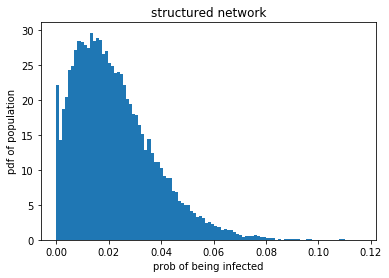

In [82]:
plt.hist([x for el in risk.values() for x in el],bins = 100,density = True)
plt.xlabel('prob of being infected')
plt.ylabel('pdf of population')
plt.title('structured network')


Parallel version of cavity dynamics, which is really slower

In [5]:
#neighbours = neigh[j]
def cavity_individuals(neighbours,j,states2): 
            values = []
            for idx,mu in enumerate(neighbours):
                new=1.
                for nu in set(neighbours)-{mu}:
                    #print(nu,states2[nu][neigh[nu]==j])
                    new*=(1-states2[nu][neigh[nu]==j])
                values +=[1-new]
            return np.ravel(values)
#neighbours = neigh[mu]
def cavity_clusters(neighbours,mu,states2):
            #running 2nd equation
            values = []
            for idx,i in enumerate(neighbours):
                new=1.
                for j in set(neighbours)-{i}:
                    new*=(1-p*states2[j][neigh[j]==mu])
                values += [1-new]
            return np.ravel(values)
N_iterations = 5
states2= {key:np.ones(len(value)) for key,value in neigh.items()}#states[x][y] indicates the state of node "x cavity neigh[x][y]""
start =time.time()

for count in range(N_iterations):    #solving cavity equations through forward dynamics
    pool = Pool()
    values = itertools.starmap(cavity_individuals,[(neigh[j],j,{nu:states2[nu] for nu in neigh[j]})
                                              for j in np.arange(N_a)])
    states2 = {**states2,**dict(zip(range(N_a),values))}
    values = itertools.starmap(cavity_clusters,[(neigh[mu],mu,{j:states2[j] for j in neigh[mu]})
                                              for mu in np.arange(N_a,N_a+N_b)])
    states2 = {**states2,**dict(zip(range(N_a,N_a+N_b),values))}
    pool.close()
end = time.time()

print(end-start)

58.57775902748108


In [250]:
1/4,5/8*4/10

(0.25, 0.25)

In [253]:
1/4,5/8*4/10

(0.25, 0.25)

In [252]:
2*1/2,5/2*4/10

(1.0, 1.0)

In [18]:
a = np.zeros(3)
a.a

AttributeError: 'numpy.ndarray' object has no attribute 'append'

Text(0, 0.5, 'degree')

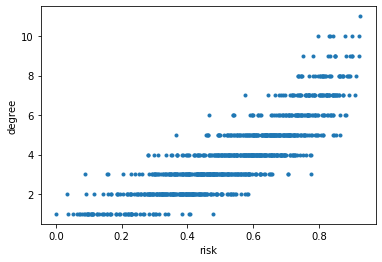

In [41]:
plt.plot(list(risk2.values()),[BG.degree(key) for key in risk2.keys()],'.')
plt.xlabel('risk')
plt.ylabel('degree')

In [39]:
projected = nx.algorithms.bipartite.projected_graph(BG,range(N_a))
%time a = nx.algorithms.percolation_centrality(projected,states=dict(risk2))

CPU times: user 8.51 s, sys: 60.5 ms, total: 8.57 s
Wall time: 8.66 s


In [72]:
b = nx.betweenness_centrality(BG.subgraph(nx.connected.node_connected_component(BG,0).intersection(set(range(N_a)))))

In [70]:
plt.plot([dict(risk2)[key]for key in b.keys()],[b[key] for key in b.keys()],'.')


KeyError: 1000

In [58]:
BG.subgraph(nx.connected.node_connected_component(BG,0))